# Network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
[Networkx](https://networkx.github.io/documentation/stable/) is a Python module that provides tools for analyzing networks in various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. [OSMnx](https://github.com/gboeing/osmnx) package that we just explored in previous tutorial, makes it really easy to retrieve routable networks from OpenStreetMap with different transport modes (walking, cycling and driving). OSMnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing along OpenStreetMap data.

Next we will test the routing functionalities of OSMnx by finding a shortest path between two points based on drivable roads. With tiny modifications, it is also possible to repeat the analysis for the walkable street network.

## Get the network

Let's again start by importing the required modules

In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
%matplotlib inline
import seaborn as sns
import folium

When fetching netowrk data from OpenStreetMap using OSMnx, it is possible to define the type of street network using the `network_type` parameter (options: `drive`, `walk` and `bike`).
Let's download the OSM data from Haiti's capital ort-au-Prince but this only the drivable network. Alternatively, you can also fetch the walkable network (this will take a bit longer time). 

In [3]:
# Define place name
place_name = "Port-au-Prince, Haiti"
graph = ox.graph_from_place(place_name, network_type='drive')
# Get the drivable (or walkable) network

Plot the graph:

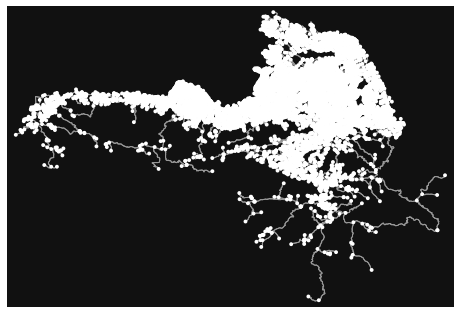

In [51]:
fig, ax = ox.plot_graph(graph)

Okey so now we have retrieved only such streets where it is possible to drive with a car. Let's confirm
this by taking a look at the attributes of the street network. Easiest way to do this is to convert the
graph (nodes and edges) into GeoDataFrames.

Converting graph into a GeoDataFrame can be done with function `graph_to_gdfs()` that we already used in previous tutorial. With parameters `nodes` and `edges`, it is possible to control whether to retrieve both nodes and edges from the graph. 

In [5]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [6]:
# Check columns
edges.columns

Index(['osmid', 'oneway', 'name', 'highway', 'length', 'geometry', 'lanes',
       'bridge', 'width', 'ref', 'junction', 'access', 'maxspeed'],
      dtype='object')

In [7]:
# Check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Note that the CRS of the GeoDataFrame is be WGS84 (epsg: 4326).

In [8]:
edges.head()

osmid  oneway                    name  \
u         v          key                                             
258604112 621694911  0    30951697    True  Boulevard Harry Truman   
          6695612844 0    48229774   False           Rue Bonne Foi   
          6695612843 0    48330154   False     Boulevard la Saline   
258604192 612968862  0    48229757   False       Rue Antonio Macéo   
          613996058  0    30951697    True  Boulevard Harry Truman   

                               highway   length  \
u         v          key                          
258604112 621694911  0       secondary   16.086   
          6695612844 0    unclassified   44.642   
          6695612843 0       secondary   48.580   
258604192 612968862  0     residential   11.787   
          613996058  0       secondary  210.727   

                                                                   geometry  \
u         v          key                                                      
258604112 621694911  0    LINESTRING (-72.34831 18.55101, -72.34838 18.5...   
          6695612844 0    LINESTRING (-72.34831 18.55101, -72.34791 18.5...   
          6695612843 0    LINESTRING (-72.34831 18.55101, -72.34818 18.5...   
258604192 612968862  0    LINESTRING (-72.34879 18.54868, -72.34868 18.5...   
          613996058  0    LINESTRING (-72.34879 18.54868, -72.34877 18.5...   

                         lanes bridge width  ref junction access maxspeed  
u         v          key                                                   
258604112 621694911  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          6695612844 0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          6695612843 0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
258604192 612968862  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          613996058  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN

Okey, so we have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them.
Most of the attributes come directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids. You can click on the links to get more information about each attribute:


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


# Perform Data Explotaroy Analysis

In [30]:
def basic_eda(df, datafile_name="Datafile name"):
    print(f"\n**************************",datafile_name,"******************************\n")
    print(f"Performing basic EDA on {datafile_name} dataset\n")
    print(f"* The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
    print("\n* First 10 rows of the dataset:\n")
    display(df.head(10))
    print("\n* Describing the dataset statistics:\n", )
    display(df.describe())
    print("\n* Fetching info of the dataset: \n")
    display(df.info())
#     print("\n* Check data distribution: ")
#     df.hist(figsize=(20,30))

In [31]:
df_edges = pd.DataFrame(edges)
basic_eda(df_edges, "Haiti Roads Data from OSM")


************************** Haiti Roads Data from OSM ******************************

Performing basic EDA on Haiti Roads Data from OSM dataset

* The dataset has 32454 rows and 13 columns.

* First 10 rows of the dataset:



osmid  oneway  \
u         v          key                                                     
258604112 621694911  0                                    30951697    True   
          6695612844 0                                    48229774   False   
          6695612843 0                                    48330154   False   
258604192 612968862  0                                    48229757   False   
          613996058  0                                    30951697    True   
258604240 612969247  0                                    48229776   False   
          621694911  0                                    48330259    True   
258604349 613770744  0                                    48769511    True   
                     1    [48306761, 66723746, 48718723, 48718722]   False   
258604432 614152805  0             [673724953, 48385002, 23861022]    True   

                                                                     name  \
u         v          key                                                    
258604112 621694911  0                             Boulevard Harry Truman   
          6695612844 0                                      Rue Bonne Foi   
          6695612843 0                                Boulevard la Saline   
258604192 612968862  0                                  Rue Antonio Macéo   
          613996058  0                             Boulevard Harry Truman   
258604240 612969247  0                                     Impasse French   
          621694911  0                             Boulevard Harry Truman   
258604349 613770744  0                             Boulevard Harry Truman   
                     1    [3ème Ruelle Plus, 3e Ruelle Plus, Rue l'Union]   
258604432 614152805  0                             Boulevard Harry Truman   

                               highway   length  \
u         v          key                          
258604112 621694911  0       secondary   16.086   
          6695612844 0    unclassified   44.642   
          6695612843 0       secondary   48.580   
258604192 612968862  0     residential   11.787   
          613996058  0       secondary  210.727   
258604240 612969247  0     residential   82.371   
          621694911  0       secondary   68.094   
258604349 613770744  0       secondary  157.555   
                     1     residential  491.751   
258604432 614152805  0       secondary   29.268   

                                                                   geometry  \
u         v          key                                                      
258604112 621694911  0    LINESTRING (-72.34831 18.55101, -72.34838 18.5...   
          6695612844 0    LINESTRING (-72.34831 18.55101, -72.34791 18.5...   
          6695612843 0    LINESTRING (-72.34831 18.55101, -72.34818 18.5...   
258604192 612968862  0    LINESTRING (-72.34879 18.54868, -72.34868 18.5...   
          613996058  0    LINESTRING (-72.34879 18.54868, -72.34877 18.5...   
258604240 612969247  0    LINESTRING (-72.34851 18.55029, -72.34775 18.5...   
          621694911  0    LINESTRING (-72.34851 18.55029, -72.34837 18.5...   
258604349 613770744  0    LINESTRING (-72.34995 18.53683, -72.35007 18.5...   
                     1    LINESTRING (-72.34995 18.53683, -72.35047 18.5...   
258604432 614152805  0    LINESTRING (-72.34981 18.53686, -72.34980 18.5...   

                         lanes bridge width  ref junction access maxspeed  
u         v          key                                                   
258604112 621694911  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          6695612844 0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          6695612843 0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
258604192 612968862  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          613996058  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
258604240 612969247  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
          621694911  0     Na


* Describing the dataset statistics:



,length
count,32454.000000
mean,135.142369
std,221.557048
min,0.203000
25%,50.826500
50%,89.750500
75%,156.827000
max,8998.235000



* Fetching info of the dataset: 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 32454 entries, (258604112, 621694911, 0) to (8488479797, 612969120, 0)
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     32454 non-null  object  
 1   oneway    32454 non-null  bool    
 2   name      24724 non-null  object  
 3   highway   32454 non-null  object  
 4   length    32454 non-null  float64 
 5   geometry  32454 non-null  geometry
 6   lanes     936 non-null    object  
 7   bridge    394 non-null    object  
 8   width     4 non-null      object  
 9   ref       1330 non-null   object  
 10  junction  87 non-null     object  
 11  access    317 non-null    object  
 12  maxspeed  221 non-null    object  
dtypes: bool(1), float64(1), geometry(1), object(10)
memory usage: 4.4+ MB


None

## Let's take a look what kind of features we have in the `highway` column:

In [32]:
print(edges['highway'].value_counts())

residential                      22271
unclassified                      4432
tertiary                          3105
secondary                         1466
primary                            719
[unclassified, residential]        167
living_street                      128
road                                68
secondary_link                      31
tertiary_link                       13
[unclassified, tertiary]            12
[living_street, residential]        10
[road, residential]                  9
[unclassified, road]                 6
[residential, living_street]         6
primary_link                         4
[unclassified, living_street]        4
[tertiary, road]                     2
[residential, road]                  1
Name: highway, dtype: int64


### You can process the retrieved data with any tool of your choice (Pandas in our case) or visualize your data with any of the Python libraries. Let us say we want to get the bar chart of street types. The following process is just pure pandas functionality with seaborn data visualisation.

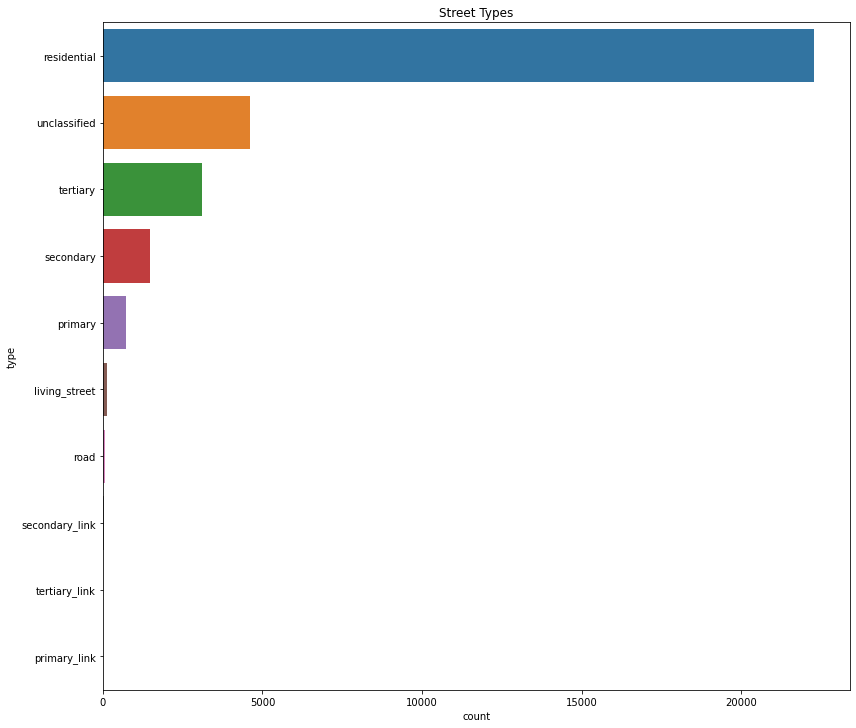

In [33]:
street_types = pd.DataFrame(edges["highway"].apply(pd.Series)[0].value_counts().reset_index())
street_types.columns = ["type", "count"]
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(y="type", x="count", data=street_types, ax=ax)
plt.tight_layout()
# plt.savefig("barchart.png")
plt.title('Street Types');

## Let's take a look what kind of features we have in the `oneway` column:

In [34]:
print(edges['oneway'].value_counts())

False    31476
True       978
Name: oneway, dtype: int64


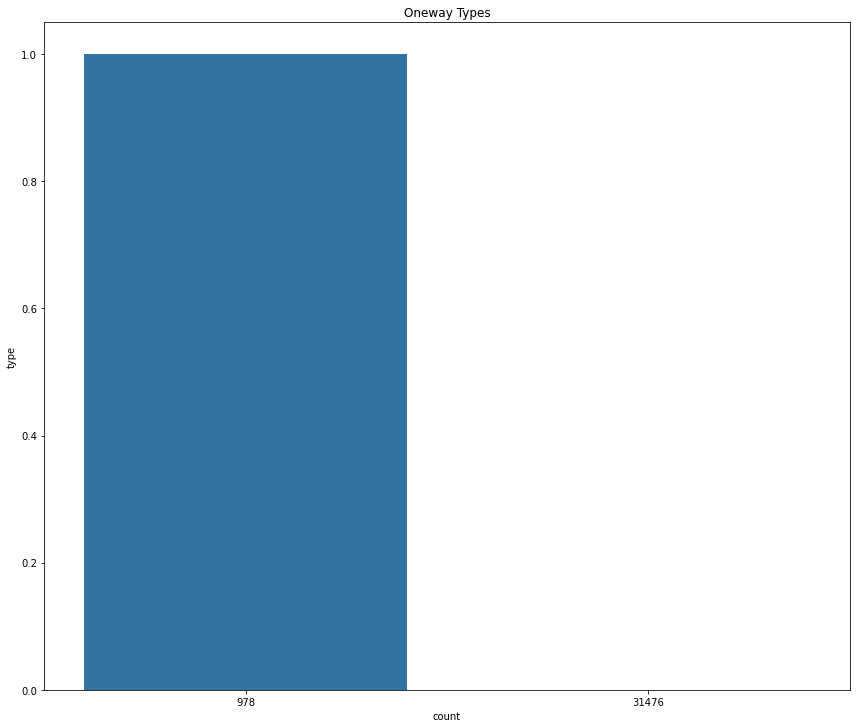

In [37]:
oneway_types = pd.DataFrame(edges["oneway"].apply(pd.Series)[0].value_counts().reset_index())
oneway_types.columns = ["type", "count"]
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(y="type", x="count", data=oneway_types, ax=ax)
plt.tight_layout()
plt.title('Oneway Types');

## Let's take a look what kind of features we have in the `lanes` column:

In [35]:
print(edges['lanes'].value_counts())

2         681
1         183
4          29
3          28
[2, 3]      4
[4, 3]      4
[2, 4]      3
0           2
[2, 1]      2
Name: lanes, dtype: int64


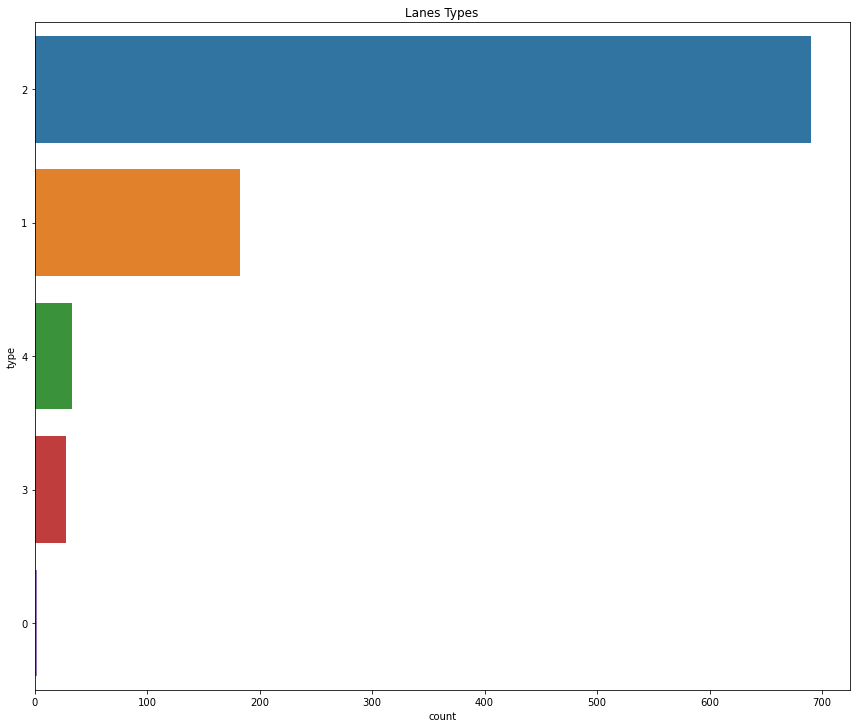

In [36]:
lane_types = pd.DataFrame(edges["lanes"].apply(pd.Series)[0].value_counts().reset_index())
lane_types.columns = ["type", "count"]
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(y="type", x="count", data=lane_types, ax=ax)
plt.tight_layout()
plt.title('Lanes Types');

## Let's take a look what kind of features we have in the `length` column:

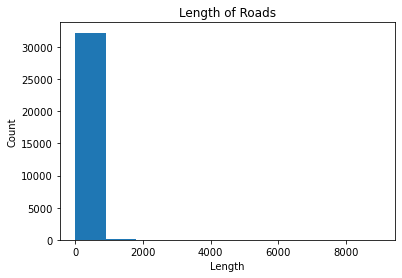

In [47]:
plt.hist(edges['length'])
plt.title('Length of Roads')
plt.xlabel('Length') 
plt.ylabel('Count');

## Missing data percentage and count for each attribute

In [12]:
percent = (edges.isnull().sum()/edges.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = edges.isna().sum().sort_values(ascending = False)
missing_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Missing Count"])
missing_data.head(20)

,Percent,Missing Count
width,99.99,32450
junction,99.73,32367
maxspeed,99.32,32233
access,99.02,32137
bridge,98.79,32060
lanes,97.12,31518
ref,95.90,31124
name,23.82,7730
osmid,0.00,0
oneway,0.00,0


## We can also use maps to visualise the street data by using any of your favourite Geospatial visualisation tool in Python. I use here Folium.

In [50]:
style = {'color': '#F7DC6F', 'weight':'1'}
m = folium.Map([-2.914018, 53.366925],
zoom_start=15)
# tiles="CartoDb dark_matter")
folium.GeoJson(edges.sample(), style_function=lambda x: style).add_to(m)
m.save("edges.html")
m

Okay, now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways or footways included in the data.

As the data is in WGS84 format, we might want to reproject our data into a metric system before proceeding to the shortest path analysis.
We can re-project the graph from latitudes and longitudes to an appropriate UTM zone using the [project_graph()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function from OSMnx. 

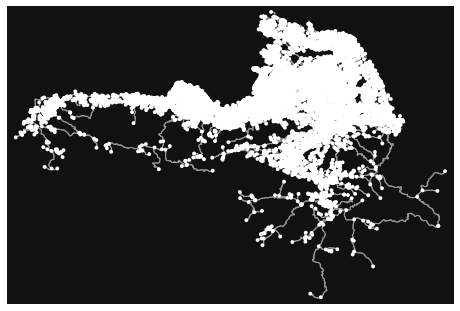

In [52]:
# Project the data
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)

In [53]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [54]:
# Check crs
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [55]:
# First rows
edges_proj.head()

osmid  oneway                    name  \
u          v          key                                             
258604112  621694911  0    30951697    True  Boulevard Harry Truman   
           6695612844 0    48229774   False           Rue Bonne Foi   
           6695612843 0    48330154   False     Boulevard la Saline   
621694911  258604192  0    30951697    True  Boulevard Harry Truman   
6695612844 612969262  0    48229774   False           Rue Bonne Foi   

                                highway   length  \
u          v          key                          
258604112  621694911  0       secondary   16.086   
           6695612844 0    unclassified   44.642   
           6695612843 0       secondary   48.580   
621694911  258604192  0       secondary  252.976   
6695612844 612969262  0    unclassified   33.082   

                                                                    geometry  \
u          v          key                                                      
258604112  621694911  0    LINESTRING (779909.922 2053210.843, 779902.664...   
           6695612844 0    LINESTRING (779909.922 2053210.843, 779953.050...   
           6695612843 0    LINESTRING (779909.922 2053210.843, 779923.642...   
621694911  258604192  0    LINESTRING (779902.664 2053196.536, 779892.443...   
6695612844 612969262  0    LINESTRING (779953.050 2053199.051, 779985.009...   

                          lanes bridge width  ref junction access maxspeed  
u          v          key                                                   
258604112  621694911  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
           6695612844 0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
           6695612843 0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
621694911  258604192  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN  
6695612844 612969262  0     NaN    NaN   NaN  NaN      NaN    NaN      NaN

Okay, as we can see from the CRS the data is now in [UTM projection](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) using zone 35 which is the one used for Finland, and indeed the orientation of the map and the geometry values also confirm this.


Furthermore, we can check the epsg code of this projection using pyproj CRS:

In [56]:
CRS(edges_proj.crs).to_epsg()

32618

Indeed, the projection is now [WGS 84 / UTM zone 35N, EPSG:32635](https://epsg.io/32635).

## Analyzing the network properties

Now as we have seen some of the basic functionalities of OSMnx such as downloading the data and converting data from graph to GeoDataFrame, we can take a look some of the analytical features of omsnx. Osmnx includes many useful functionalities to extract information about the network.

To calculate some of the basic street network measures we can use [basic_stats()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats) function in OSMnx:

In [57]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')
stats

{'n': 12913,
 'm': 32454,
 'k_avg': 5.026562378997909,
 'intersection_count': 9635,
 'streets_per_node_avg': 2.5903353209943467,
 'streets_per_node_counts': {0: 0, 1: 3278, 2: 2, 3: 8372, 4: 1254, 5: 7},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.2538527065747696,
  2: 0.0001548826763726477,
  3: 0.6483388832959034,
  4: 0.09711143808565012,
  5: 0.000542089367304267},
 'edge_length_total': 4385910.448999984,
 'edge_length_avg': 135.142369168669,
 'street_length_total': 2239063.0790000022,
 'street_length_avg': 133.9473007298398,
 'street_segments_count': 16716,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.1127359694111068,
 'self_loop_proportion': 0.0007703210698219018,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. Let's calculate the area of the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of the street network and see what we can get.



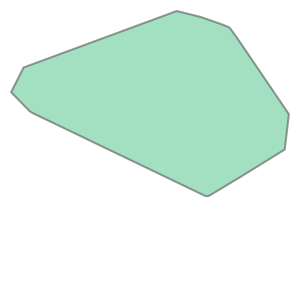

In [58]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Show output
convex_hull

Now we can use the Convex Hull above to calculate [extended statistics for the network](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.extended_stats). As some of the metrics are produced separately for each node, they produce a lot of output. Here, we combine the basic and extended statistics into one pandas Series to keep things in more compact form.

In [59]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value
    
# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

KeyboardInterrupt: 

As we can see, now we have a **LOT** of information about our street network that can be used to understand its structure. We can for example see that the average node density in our network is `149 nodes/km` and that the total edge length of our network is almost 20 kilometers.

Furthermore, we can see that the [degree centrality](https://en.wikipedia.org/wiki/Centrality) of our network is on average `0.0326515`. Degree is a simple centrality measure that counts how many neighbors a node has (here a fraction of nodes it is connected to). Another interesting measure is the [PageRank](https://en.wikipedia.org/wiki/PageRank) that measures the importance of specific node in the graph. Here we can see that the most important node in our graph seem to a node with osmid `25416262`. PageRank was the algorithm that Google first developed (Larry Page & Sergei Brin) to order the search engine results and became famous for.

You can read the [Wikipedia article about different centrality measures](https://en.wikipedia.org/wiki/Centrality) if you are interested what the other centrality measures mean.

## Shortest path analysis

Let's now calculate the shortest path between two points using the [shortest path function in Networkx](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#shortest-path). 

#### Origin and destination points 

First we need to specify the source and target locations for our route. If you are familiar with the Haiti area, you can specify a custom placename as a source location. Or, you can choose from these options:
- [Maria 01](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01) and old hospital area and current startup hub
- [Tennispalatsi](https://nominatim.openstreetmap.org/ui/search.html?q=tennispalatsi) - a big movie theatre (*note! Routing in the drivable network will fail with this input*).

We could figure out the coordinates for these locations manually, and create shapely points based on the coordinates.
However,  it is more handy to fetch the location of our source destination directly from OSM:

In [ ]:
# Set place name
place = ""

In [ ]:
# Geocode the place name
geocoded_place = 

In [ ]:
# Check the result
geocoded_place

As output, we received the building footprint. From here, we can get the centroid as the source location of our shortest path analysis. However, we first need to project the data into the correct crs:

In [ ]:
# Re-project 


In [ ]:
# Get centroid as shapely point


Great! Now we have defined the origin point of our analysis somewhere in the area of interest. 

Next, we still need the destination location. To make things simple, we can set the easternmost node in our road network as the destination. Let's have another look at our node data:

We can find the easternmost nodes based on the x coordinates:

In [ ]:
# Retrieve the maximum x value (i.e. the most eastern)


Let's find out the coresponding point geometries for these noodes.

We can do this by using the `.loc` function of Pandas that we have used already many times in earlier tutorials.

In [ ]:
# Easternmost point


#### Nearest node

Let's now find the nearest graph nodes (and their node IDs) to these points using OSMnx [get_nearest_node](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.get_nearest_node). 
As a starting point, we have the two Shapely Point objects we just defined as the origin and destination locations. 

According to the documentation of this function, we need to parse Point coordinates as coordinate-tuples in this order: `latitude, longitude`(or `y, x`). As our data is now projected to UTM projection, we need to specify with `method` parameter that the function uses `'euclidean'` distances to calculate the distance from the point to the closest node (with decimal derees, use `'haversine'`, which determines the great-circle distances). The method parameter is important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter `return_dist=True`.


In [ ]:
# Get origin x and y coordinates
orig_xy = 

# Get target x and y coordinates
target_xy = 

In [ ]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node_id = 


In [ ]:
# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node_id = 


Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified. 

Let's retrieve the node information from the `nodes_proj` GeoDataFrame by passing the ids to the `loc` indexer

In [ ]:
# Retrieve the rows from the nodes GeoDataFrame based on the node id (node id is the index label)
orig_node = 
target_node = 

Let's also create a GeoDataFrame that contains these points

In [ ]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

Okay, as a result we got now the closest node IDs of our origin and target locations. As you can see, the `index` in this GeoDataFrame corresponds to the IDs that we found with `get_nearest_node()` function.

#### Routing

Now we are ready to do the routing and find the shortest path between the origin and target locations
by using the `shortest_path()` [function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) of networkx.
With `weight` -parameter we can specify that `'length'` attribute should be used as the cost impedance in the routing. If specifying the weight parameter, NetworkX will use by default Dijkstra's algorithm to find the optimal route. We need to specify the graph that is used for routing, and the origin `ID` (*source*) and the target `ID` in between the shortest path will be calculated:


In [ ]:
# Calculate the shortest path
route = 

# Show what we have


As a result we get a list of all the nodes that are along the shortest path. 

- We could extract the locations of those nodes from the `nodes_proj` GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using `plot_graph_route()` function:


In [ ]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route)

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable information for many applications.
Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the
optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

## Saving shortest paths to disk

Quite often you need to save the route e.g. as a Shapefile.
Hence, let's continue still a bit and see how we can make a Shapefile of our route with some information associated with it.

- First we need to get the nodes that belong to the shortest path:


In [ ]:
# Get the nodes along the shortest path
route_nodes = 


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

- Now we can create a LineString out of the Point geometries of the nodes:

In [ ]:
from shapely.geometry import LineString, Point

# Create a geometry for the shortest path
route_line = 

Now we have the route as a LineString geometry. 

- Let's make a GeoDataFrame out of it having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [ ]:
# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Add a list of osmids associated with the route
route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

# Calculate the route length
route_geom['length_m'] = route_geom.length

route_geom.head()

Now we have a GeoDataFrame that we can save to disk. Let's still confirm that everything is ok by plotting our route on top of our street network and some buildings, and plot also the origin and target points on top of our map.

- Get buildings:

In [ ]:
tags = {'building': True}
buildings = ox.geometries_from_place(place_name, tags)

re-project buildings

In [ ]:
buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

- Let's now plot the route and the street network elements to verify that everything is as it should:

In [ ]:
# Plot edges and nodes
ax = edges_proj.plot(linewidth=0.75, color='gray')
ax = nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=24, color='green')

Great everything seems to be in order! As you can see, now we have a full control of all the elements of our map and we can use all the aesthetic properties that matplotlib provides to modify how our map will look like. Now we are almost ready to save our data into disk.


- As there are certain columns with such data values that Shapefile format does not support (such as `list` or `boolean`), we need to convert those into strings to be able to export the data to Shapefile:

In [ ]:
# Columns with invalid values
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']

# Iterate over invalid columns and convert them to string format
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str)
    
print(edges_proj.dtypes)

Now we can see that most of the attributes are of type `object` that quite often (such as ours here) refers to a string type of data.

- Now we are finally ready to parse the output filepaths and save the data into disk:

In [ ]:
import os

# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

# Output directory
out_dir = "data"

# Parse output file paths
streets_out = os.path.join(out_dir, "%s_streets.shp" % place_name_out)
route_out = os.path.join(out_dir, "Route_from_a_to_b_at_%s.shp" % place_name_out)
nodes_out = os.path.join(out_dir, "%s_nodes.shp" % place_name_out)
buildings_out = os.path.join(out_dir, "%s_buildings.shp" % place_name_out)
od_out = os.path.join(out_dir, "%s_route_OD_points.shp" % place_name_out)

# Save files
edges_proj.to_file(streets_out)
route_geom.to_file(route_out)
nodes_proj.to_file(nodes_out)
od_nodes.to_file(od_out)
buildings[['geometry', 'name', 'addr:street']].to_file(buildings_out)

Great, now we have saved all the data that was used to produce the maps as Shapefiles.